In [1]:
!pip install ktrain

     |████████████████████████████████| 25.3MB 137kB/s 
     |████████████████████████████████| 983kB 41.5MB/s 
     |████████████████████████████████| 266kB 53.8MB/s 
     |████████████████████████████████| 1.3MB 41.3MB/s 
     |████████████████████████████████| 1.1MB 42.7MB/s 
     |████████████████████████████████| 471kB 47.9MB/s 
     |████████████████████████████████| 2.9MB 50.7MB/s 
     |████████████████████████████████| 890kB 42.9MB/s 
  Created wheel for ktrain: filename=ktrain-0.25.2-cp36-none-any.whl size=25276306 sha256=4b9780a73203f86d29e6f1d8cf18cd522ba05139d811441276fb4b0c2f036f73
  Stored in directory: /root/.cache/pip/wheels/fe/56/00/25444c352cc843e5c5daea0e9517a192878ae22c2c6b5f4573
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993193 sha256=0bb50a2dd968a77971dd9b7c11c8cd58ef506845189a0c4788a1ee91503a0af3
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
  Created wheel for syn

In [22]:
import ktrain
from ktrain import text
import pandas as pd
import re,string

In [23]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')
df_submission = pd.read_csv('/content/sample_submission.csv')

In [24]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [40]:
df_train['text'] = df_train['text'].apply(lambda x:clean_text(x))
df_train['selected_text'] = df_train['selected_text'].apply(lambda x:clean_text(x))

In [41]:
def get_training_data(sentiment):
    '''
    Returns Training data in the format needed to train spacy NER
    '''
    train_data = []
    test_data = []
    for index, row in df_train.iterrows():
        if row.sentiment == sentiment:
            selected_text = row.selected_text
            text = row.text
            train_data.append(text.split())
            test_data.append([i if i in selected_text.split() else 0 for i in text.split()])
    return train_data,test_data

In [42]:
def get_model_out_path(sentiment):
    '''
    Returns Model output path
    '''
    model_out_path = None
    if sentiment == 'positive':
        model_out_path = '/content/models/model_pos'
    elif sentiment == 'negative':
        model_out_path = '/content/models/model_neg'
    return model_out_path

In [78]:
sentiment = 'positive'

train_data,test_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)

In [79]:
(trn, val, preproc) = text.entities_from_array(train_data, test_data,
                        x_test=None, y_test=None,
                        use_char=False,
                        val_pct=0.1,
                        verbose=1)

training data sample:
   SentenceID      Word Tag
0           0  feedings   0
1           0       for   0
2           0       the   0
3           0      baby   0
4           0       are   0
Number of sentences:  8581
Number of words in the dataset:  12046
Tags: [0, 'apart', 'article', 'generally', 'nevermind', 'virtue', 'tanning', 'grown', 'steady', 'sessionmosh', 'office', 'dayevery', 'promise', 'ripped', 'blackberry', 'loads', 'superexcited', 'promised', 'happpppy', 'though', 'dimple', 'sweeney', 'backs', 'venueswhat', 'things', 'screwing', 'humble', 'gonna', 'sad', 'wii', 'would', 'goodtimes', 'private', 'favourtie', 'itbut', 'scones', 'bitbetter', 'yum', 'force', 'forest', 'let', 'cab', 'jamie', 'cool', 'handles', 'everyoneeeee', 'stupid', 'month', 'hahahahahahahahahahahahaha', 'purrtty', 'disappoint', 'ultra', 'trek', 'asleep', 'big', 'continue', 'teeth', 'clean', 'eatin', 'macarena', 'complete', 'with', 'absolute', 'jon', 'iiight', 'w', 'grace', 'causes', 'showwwww', 'birdies', '

In [80]:
WV_URL = 'https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz'
model = text.sequence_tagger('bilstm-crf', preproc, wv_path_or_url=WV_URL)


IMPORTANT NOTE: ktrain uses the CRF module from keras_contrib, which is not yet
fully compatible with TensorFlow 2. You can still use the BiLSTM-CRF model
in ktrain for sequence tagging with TensorFlow 2, but you must add the
following to the top of your script or notebook BEFORE you import ktrain:

import os
os.environ['DISABLE_V2_BEHAVIOR'] = '1'

For this run, a vanilla BiLSTM model (with no CRF layer) will be used.

embedding schemes employed:
	word embeddings initialized with fasttext word vectors (cc.en.300.vec.gz)

pretrained word embeddings will be loaded from:
	https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
loading pretrained word vectors...this may take a few moments...


/usr/local/lib/python3.6/dist-packages/ktrain/text/ner/models.py:108: UserWarning: Falling back to BiLSTM (no CRF) because DISABLE_V2_BEHAVIOR=False
  warnings.warn('Falling back to BiLSTM (no CRF) because DISABLE_V2_BEHAVIOR=False')


In [81]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=10)

In [82]:
learner.lr_find(max_epochs=5)

simulating training for different learning rates... this may take a few moments...
preparing training data ...done.
Epoch 1/5
772/772 [==============================] - 37s 48ms/step - loss: 4.4883
Epoch 2/5
772/772 [==============================] - 37s 47ms/step - loss: 3.1871
Epoch 3/5
772/772 [==============================] - 36s 47ms/step - loss: 1.2759
Epoch 4/5
772/772 [==============================] - 36s 47ms/step - loss: 1.5504
Epoch 5/5
772/772 [==============================] - 35s 46ms/step - loss: 2.8832


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


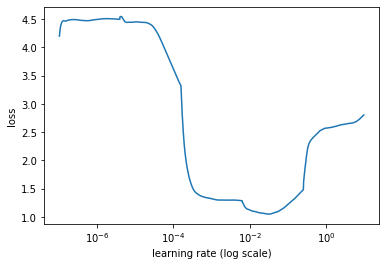

In [83]:
learner.lr_plot()

In [84]:
learner.autofit(1e-2, 5)



begin training using triangular learning rate policy with max lr of 0.01...
preparing validation data ...done.
Epoch 1/5
773/773 [==============================] - 39s 51ms/step - loss: 1.3379 - val_loss: 0.7545
Epoch 2/5
773/773 [==============================] - 37s 48ms/step - loss: 0.7740 - val_loss: 0.5421
Epoch 3/5
773/773 [==============================] - 37s 48ms/step - loss: 0.5823 - val_loss: 0.5076
Epoch 4/5
773/773 [==============================] - 36s 47ms/step - loss: 0.5023 - val_loss: 0.5191
Epoch 5/5
773/773 [==============================] - 37s 48ms/step - loss: 0.4486 - val_loss: 0.5370


In [85]:
pos_predictor = ktrain.get_predictor(learner.model, preproc)

In [86]:
pos_predictor.predict("I am happy for you")

[('I', 'i'), ('am', 'am'), ('happy', 'happy'), ('for', 0), ('you', 0)]

In [87]:
pos_predictor.save(model_path)

In [88]:
sentiment = 'negative'

neg_train_data,neg_test_data = get_training_data(sentiment)
neg_model_path = get_model_out_path(sentiment)
print(len(neg_train_data),len(neg_test_data))

7781 7781


In [89]:
(neg_trn, neg_val, neg_preproc) = text.entities_from_array(neg_train_data, neg_test_data,
                        x_test=None, y_test=None,
                        use_char=False,
                        val_pct=0.1,
                        verbose=1)

training data sample:
   SentenceID  Word   Tag
0           0  sooo  sooo
1           0   sad   sad
2           0     i     0
3           0  will     0
4           0  miss     0
Number of sentences:  7780
Number of words in the dataset:  11837
Tags: [0, 'apart', 'article', 'tanning', 'bgt', 'experiencing', 'absolutley', 'office', 'functional', 'loads', 'blackberry', 'promised', 'argghhh', 'fungus', 'though', 'throooooooooooooo', 'gabbie', 'brittany', 'spoil', 'things', 'andjay', 'bout', 'fate', 'screwing', 'gonna', 'sad', 'wii', 'would', 'unholy', 'smelly', 'baffles', 'chased', 'stone', 'force', 'proven', 'let', 'cab', 'haileys', 'johnathan', 'hole', 'cool', 'supporting', 'stupid', 'droppedcome', 'month', 'sara', 'dust', 'cholesterol', 'messy', 'disappoint', 'cuties', 'travis', 'big', 'asleep', 'owi', 'spamming', 'whaaaaaat', 'lettin', 'denial', 'teeth', 'shakalohana', 'fist', 'loadsa', 'triple', 'complete', 'with', 'dynamic', 'rated', 'clean', 'w', 'inventing', 'theese', 'funeral', 'b

In [90]:
WV_URL = 'https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz'
neg_model = text.sequence_tagger('bilstm-crf', neg_preproc, wv_path_or_url=WV_URL)

/usr/local/lib/python3.6/dist-packages/ktrain/text/ner/models.py:108: UserWarning: Falling back to BiLSTM (no CRF) because DISABLE_V2_BEHAVIOR=False
  warnings.warn('Falling back to BiLSTM (no CRF) because DISABLE_V2_BEHAVIOR=False')



IMPORTANT NOTE: ktrain uses the CRF module from keras_contrib, which is not yet
fully compatible with TensorFlow 2. You can still use the BiLSTM-CRF model
in ktrain for sequence tagging with TensorFlow 2, but you must add the
following to the top of your script or notebook BEFORE you import ktrain:

import os
os.environ['DISABLE_V2_BEHAVIOR'] = '1'

For this run, a vanilla BiLSTM model (with no CRF layer) will be used.

embedding schemes employed:
	word embeddings initialized with fasttext word vectors (cc.en.300.vec.gz)

pretrained word embeddings will be loaded from:
	https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
loading pretrained word vectors...this may take a few moments...


In [91]:
neg_learner = ktrain.get_learner(neg_model, train_data=neg_trn, val_data=neg_val, batch_size=10)

In [92]:
neg_learner.autofit(1e-2, 5)



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/5
701/701 [==============================] - 38s 55ms/step - loss: 1.5551 - val_loss: 0.9842
Epoch 2/5
701/701 [==============================] - 35s 50ms/step - loss: 0.9726 - val_loss: 0.6502
Epoch 3/5
701/701 [==============================] - 35s 50ms/step - loss: 0.6879 - val_loss: 0.5665
Epoch 4/5
701/701 [==============================] - 35s 49ms/step - loss: 0.5719 - val_loss: 0.5826
Epoch 5/5
701/701 [==============================] - 36s 51ms/step - loss: 0.5010 - val_loss: 0.6075


In [93]:
neg_predictor = ktrain.get_predictor(neg_learner.model, neg_preproc)

In [94]:
neg_predictor.predict("I am so sad")

[('I', 0), ('am', 0), ('so', 'so'), ('sad', 'sad')]

In [96]:
neg_predictor.save(neg_model_path)

In [97]:
def predict_entities(predicted_text):
    selected_text = [] 
    for ent , val in predicted_text:
        if val != 0:
          selected_text.append(ent)
    return ' '.join(selected_text)

In [101]:
selected_texts = []
model_pos = ktrain.load_predictor('/content/models/model_pos')
model_neg = ktrain.load_predictor('/content/models/model_neg')
    
for index, row in df_test.iterrows():
    text = row.text
    output_str = ""
    if row.sentiment == 'neutral' or len(text.split()) <= 2:
        selected_texts.append(text)
    elif row.sentiment == 'positive':
        selected_texts.append(predict_entities(pos_predictor.predict(text)))
    else:
        selected_texts.append(predict_entities(neg_predictor.predict(text)))
        
df_test['selected_text'] = selected_texts

In [102]:
df_submission['selected_text'] = df_test['selected_text']
df_submission.to_csv("submission.csv", index=False)
display(df_submission.head(10))

,textID,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,is also really exciting Good in
2,eee518ae67,Recession hit she to quit her such a shame
3,01082688c6,happy bday!
4,33987a8ee5,I like it
5,726e501993,great !
6,261932614e,I THINK HATES
7,afa11da83f,completely blocked
8,e64208b4ef,and within a short time of the last clue all ...
9,37bcad24ca,What did you get? My day is alright.. haven`...
